In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import scienceplots
plt.style.use('science')
from pylab import xticks,yticks,np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy.stats import gaussian_kde, norm
from sklearn.mixture import GaussianMixture

from utils_f4f import si_format
import json

In [18]:
# Import data 
assay = 'nor_package'
array = 'AA_sequence'

df_all = pd.read_csv('../data/1st_780w_packseq_aa.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['AA_sequence', 'nor_package']]
df= df.sort_values(by='nor_package')

#Fill in the nan data and replace the inf value
df['nor_package'] = df['nor_package'].fillna(0)  
df['nor_package'] = df['nor_package'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['nor_package','AA_sequence'])

#Stratified sampling
df = df.iloc[::5]
df.shape

(1561098, 2)

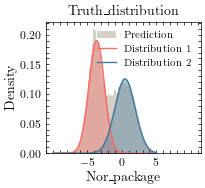

In [3]:
nor_package = df_all[np.isfinite(df_all[assay])][assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

In [19]:


def onehot_flatten(integer_vec, alphabet):
    num_labels = len(alphabet)
    one_hot = np.zeros((len(integer_vec), num_labels))
    one_hot[np.arange(len(integer_vec)), integer_vec] = 1
    return one_hot.flatten()

def seq_to_onehot(char_sequences, alphabet):
    char_to_int = {c: i for i, c in enumerate(alphabet)}
    integer_encoded = [[char_to_int[char] for char in seq] for seq in char_sequences]
    integer_encoded = pd.DataFrame(integer_encoded)
    
    one_hot_encoded_list = []
    for index, row in integer_encoded.iterrows():
        one_hot_encoded_list.append(onehot_flatten(row, alphabet))
    
    one_hot_encoded = pd.DataFrame(one_hot_encoded_list, dtype='int')
    
    return one_hot_encoded, integer_encoded

# Define alphabet
alphabet = 'ACDEFGHIKLMNPQRSTVWY'
# Apply one-hot encoding
X, integer_encoded = seq_to_onehot(list(df['AA_sequence']), alphabet=alphabet)

In [5]:
X

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156105,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
156106,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
156107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156108,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
aa_values_list  = X
nor_package_values_list = df['nor_package']



In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train = aa_values_list  # Replace with your encoded sequences
y_train = nor_package_values_list  # Replace with your corresponding activity values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train a Gradient Boosting regression model
model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.2, max_depth=5, random_state=42)  
# You can adjust parameters such as n_estimators, learning_rate, and max_depth

model.fit(X_train, y_train)

# Make predictions on the test set
predicted_activity = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]


x_both.corrwith(y_both)

Mean Squared Error: 3.3725057907756897
R-squared: 0.42360642411774285


0    0.650882
dtype: float64

C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


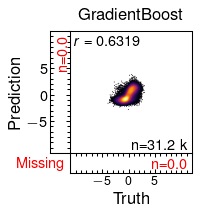

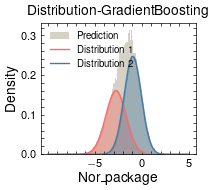

In [12]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
plt.title('GradientBoost',fontsize=8)
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
fig.savefig('aa_nor_package_correlation_GradientBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()


nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-GradientBoosting',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_nor_package_distribution_GradientBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()

